Generate GLCM features and train a SVM with them

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import mahotas as mt
import os
import multiprocessing
import sys
from sklearn import svm, metrics, decomposition, preprocessing
from sklearn.model_selection import train_test_split, GridSearchCV
from joblib import Parallel, delayed

sys.path.append('/data/simon/Code/MasterThesis/project/include')
%matplotlib inline
plt.rcParams['figure.figsize'] = [16, 8]
import utils as utl


BASE_DATA_PATH = '/data/simon/ownCloud/Data/'

print(f'INFO> Using python version {sys.version_info}')
print(f'INFO> Using opencv version {cv2.__version__}')

INFO> Using python version sys.version_info(major=3, minor=6, micro=8, releaselevel='final', serial=0)
INFO> Using opencv version 4.1.1


UTIL> Loading picture /data/simon/ownCloud/Data/QA Dataset/E006L.png


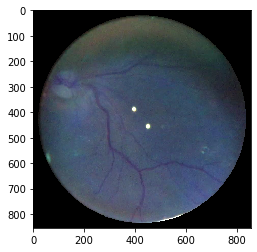

In [2]:
image = utl.load_image(BASE_DATA_PATH + 'QA Dataset/E006L.png')
image_enhanced = utl.enhance_contrast_image(image, clip_limit=3.5, tile_size=12)
mask, circle = utl.get_retina_mask(image_enhanced)
image = utl.crop_to_circle(cv2.bitwise_and(image, mask), circle)
plt.imshow(image)

## Dataset Preperation and Feature Extraction

In [10]:
#properties = ['contrast', 'dissimilarity', 'homogeneity', 'energy', 'correlation', 'ASM']
def extract_feature_vector(img: np.array) -> np.array:
    channels = cv2.split(img)
    features = []
    for c in channels:
         textures: np.array = mt.features.haralick(c)
         ht_mean = textures.mean(axis=0)
         ht_range = np.ptp(textures, axis=0)
         f = np.hstack((ht_mean, ht_range))
         features.append(f)
    return np.hstack(features)

print(extract_feature_vector(image))

def create_train_data(path, train_feats, train_lbs, cur_label):
    files = os.listdir(path)
    print(f'Reading {len(files)} from {path} into dataset')
    for p in files:
        feat = extract_feature_vector(cv2.imread(os.path.join(path, p)))
        train_feats.append(feat)
        train_lbs.append(cur_label)


[ 8.20440879e-02  1.98128748e+01  9.90891159e-01  1.08770876e+03
  6.29611183e-01  9.40590335e+01  4.33102218e+03  5.86007696e+00
  7.42533735e+00  1.19203943e-03  2.19848310e+00 -5.54320936e-01
  9.98219525e-01  1.29810458e-03  1.66740975e+01  7.67547570e-03
  1.31700753e+00  8.18312574e-02  1.10203906e-01  2.19421276e+01
  2.05454577e-02  3.52333619e-01  2.94246729e-04  3.73023736e-01
  6.75012213e-02  1.18685567e-03  8.24818956e-02  2.13322838e+01
  9.92741032e-01  1.46959493e+03  6.41916321e-01  1.12839937e+02
  5.85704745e+03  5.78043618e+00  7.29365529e+00  1.23070354e-03
  2.14706265e+00 -5.57740557e-01  9.98125900e-01  1.44897731e-03
  1.81411107e+01  6.18175246e-03  2.00775259e+00  8.02176768e-02
  1.32208480e-01  2.61721211e+01  1.62391329e-02  3.55744932e-01
  2.96934036e-04  3.75767588e-01  6.92610270e-02  1.26477685e-03
  8.17178269e-02  2.35690061e+01  9.95096679e-01  2.40368474e+03
  6.33185141e-01  1.39810129e+02  9.59116995e+03  6.21649894e+00
  7.76786697e+00  1.20228

In [ ]:
x_train = []
y_train = []
train_pos_path = os.path.join(BASE_DATA_PATH, 'Snippets/', '_frames_positive_processed')
train_neg_path = os.path.join(BASE_DATA_PATH, 'Snippets/', '_frames_negative_processed')

create_train_data(train_pos_path, x_train, y_train, 0)
create_train_data(train_neg_path, x_train, y_train, 1)

Reading 299 from /data/simon/ownCloud/Data/Snippets/_frames_positive_processed into dataset
Reading 803 from /data/simon/ownCloud/Data/Snippets/_frames_negative_processed into dataset


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.1, shuffle=True) # 70% training and 30% test

print("Training features: {}".format(np.array(X_train).shape))
print("Training labels: {}".format(np.array(y_train).shape))
print("Test features: {}".format(np.array(X_test).shape))
print("Test labels: {}".format(np.array(y_test).shape))

In [ ]:
pca = decomposition.PCA(n_components=0.99)
scaler = preprocessing.MinMaxScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
#fit = pca.fit(X_train)

#X_train = pca.transform(X_train)
#X_test = pca.transform(X_test)

print(f'PCA reduced features from {np.array(x_train).shape[1]} to {np.array(X_train).shape[1]}')

## Training SVM Classifier (Grid search over C value)

In [ ]:
#%time
classifier = svm.SVC(cache_size=1000)
gsc = GridSearchCV(estimator=classifier, param_grid=[
                        {'C': [0.1, 1, 100, 1000, 10000], 'kernel': ['linear']},
                        #{'C': [10000, 1000, 100, 10, 1.0], 'gamma': ['auto'], 'kernel': ['rbf']}
                    ], cv=5, scoring='precision', verbose=10, n_jobs=-1)

grid_result = gsc.fit(X_train, y_train)
best_params = grid_result.best_params_
print(f'SVM using best parameters: {best_params}')
#clf_svm = SVC(C=10.0, kernel='linear', verbose=True)
#clf_svm.fit(np.array(X_train), np.array(y_train))

In [ ]:
#best_svc = svm.SVC(kernel='rbf', C=best_params['C'], gamma='auto', coef0=0.1, shrinking=True, tol=0.001, cache_size=1000, verbose=3, max_iter=-1)
best_svc = svm.SVC(kernel=best_params['kernel'], C=best_params['C'], shrinking=True, tol=0.001, cache_size=1000, verbose=3, max_iter=-1)
best_svc.fit(X_train, y_train, sample_weight=)

In [ ]:
y_pred = best_svc.predict(X_test)
print(f'SVM Prediction: {y_pred}, ground truth: {y_test}')

print("Precision: ", metrics.precision_score(y_test, y_pred))
print("Recall: ", metrics.recall_score(y_test, y_pred))
print("F1: ", metrics.f1_score(y_test, y_pred))
print(f'SVM using best parameters: {best_params}')


## Results SVM
### linear SVM, standard scaler, C=1000
- Precision:  0.9166666666666666
- Recall:  0.9506172839506173
- F1:  0.9333333333333332

### linear SVM, min/max scaler, C=1000
- Precision:  0.9390243902439024
- Recall:  0.9625
- F1:  0.9506172839506174